# **IoT Agent - JSON Version**
IoT Agent for a JSON based protocol with AMQP, HTTP, MQTT transports is a bridge between JSON and the NGSI interface of a context broker.

## Connecting IoT Devices
Note: all provisioning requests to the IoT Agent require two mandatory headers: - *fiware-service* header is defined so that entities for a given service can be held in a separate mongoDB database - *fiware-servicepath* can be used to differentiate between arrays of devices. Provisioning a Service Group Invoking group provision is always the first step in connecting devices since it is always necessary to supply an authentication key with each measurement and the IoT Agent will not initially know which URL the context broker is responding on. Telling the IoT Agent that a series of devices will be sending messages to the IOTA_HTTP_PORT, i.e. port 7896 (where the IoT Agent is listening for Northbound communications):

In [ ]:
from ngsildclient import Client
orionld_ctxbrk= Client("localhost", 1026, tenant="openiot", overwrite=True)

import requests
from requests.structures import CaseInsensitiveDict

url = "http://localhost:4041/iot/services"
headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json"
headers["fiware-service"] = "openiot"
headers["fiware-servicepath"] = "/"

#entity_type attribute provides a default type for each device which has made a request (in this case anonymous devices will be known as thing entities)
#the location of the context broker (cbroker) is needed, so that the IoT Agent can pass on any measurements received to the correct location.
data = """
{
 "services": [
   {
     "apikey":      "4jggokgpepnvsb2uv4s40d59ov",
     "cbroker":     "http://orion:1026",
     "entity_type": "Thing",
     "resource":    "/iot/json"
   }
 ]
}
"""
#the IoT Agent is now informed that the /iot/json endpoint will be used and that devices will authenticate themselves by including the token 4j etc. For a JSON IoT Agent this means devices will be 
#sending GET or POST requests to http://iot-agent:7896/iot/json?i=<device_id>&k=4jggokgpepnvsb2uv4s40d59ov
resp = requests.post(url, headers=headers, data=data)
print(resp.status_code)

## Device Provisioning
Once the service group has been created, it is necessary to register the devices that will interact with IoT Agent. The registration must relate to one of the service groups created (in this case openiot).
Three types of measurement attributes can be provisioned:
- *attributes* are active readings from the device
- *lazy attributes* are only sent on request - The IoT Agent will inform the device to return the measurement
- *static_attributes* are as the name suggests static data about the device (such as relationships) passed on to the context broker.

In [ ]:
url = "http://localhost:4041/iot/devices"
headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json"
headers["fiware-service"] = "openiot"
headers["fiware-servicepath"] = "/"
data2 = """
{
 "devices": [
   {
     "device_id":   "motion004",
     "entity_name": "urn:ngsi-ld:Motion:004",
     "entity_type": "Motion",
     "timezone":    "Europe/Berlin",
     "attributes": [
       { "object_id": "c", "name": "count", "type": "Integer" }
     ],
     "static_attributes": [
       { "name":"refStore", "type": "Relationship", "value": "urn:ngsi-ld:Store:001"}
     ]
   }
 ]
}
"""
resp = requests.post(url, headers=headers, data=data2)
print(resp.status_code)
print(resp)


## HTTP Northbound communication
Here is an example of northbound communication. The device (in this case emulated) makes an http call to port 7896, providing the apikey to authenticate itself and the id of the device that is communicating. 

In [ ]:
#sending data

url_south = "http://localhost:7896/iot/json?k=4jggokgpepnvsb2uv4s40d59ov&i=motion001"

headers = CaseInsensitiveDict()
headers["Content-Type"] = "application/json"
headers["fiware-service"] = "openiot"
headers["fiware-servicepath"] = "/"
data = """{"c": "1"}"""
resp = requests.post(url_south, headers=headers, data=data)
print(resp.status_code)


## MQTT communication
To have MQTT communication with a device, a dedicated MQTT broker must be deployed to interface with IoT Agent. In the example shown, Mosquitto was deployed in the container version. Communication from the devices will then take place by sending MQTT messages to the broker. This, in turn, will be connected to the IoT Agent. This connection is ensured by the environment variable settings of the docker-compose file:

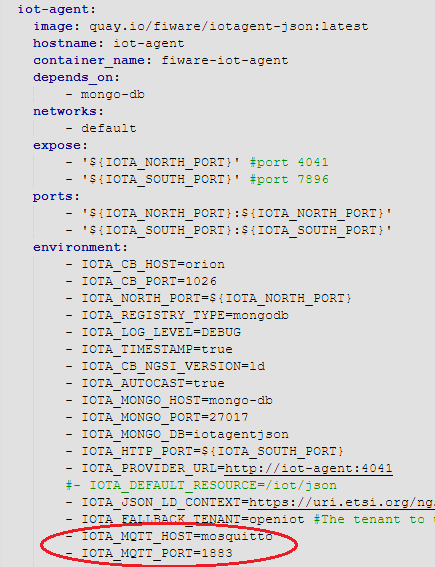

Once the IoT Agent - MQTT Broker connection is established, simply connect to the MQTT broker and send data using the api key of the correct service group and the id of the device in object. Using *mosquitto_pub* command:
mosquitto_pub -m "{\"c\": \"6\"}" -t json/4jggokgpepnvsb2uv4s40d59ov/motion001/attrs -d
the terminal will publish a new value (c=6) regarding the *motion001* device.
*Note*: alternatively, MQTTX can be used to send data to the hemostat broker